In [1]:
from xml_tools import get_abstract_contents
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial import distance_matrix
from sklearn import manifold
from tqdm import tqdm

In [2]:
import glob
from os import path



In [3]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [4]:
xmls = glob.glob('../articles_from_tatiana/batch3_header_xml/*.xml')

xmls[:10]

['../articles_from_tatiana/batch3_header_xml/Grieger 2003.xml',
 '../articles_from_tatiana/batch3_header_xml/Xu et al 2020.xml',
 '../articles_from_tatiana/batch3_header_xml/Cao et al 2019.xml',
 '../articles_from_tatiana/batch3_header_xml/Mantin et al 2014.xml',
 '../articles_from_tatiana/batch3_header_xml/Li 2020.xml',
 '../articles_from_tatiana/batch3_header_xml/Shen et al 2019.xml',
 '../articles_from_tatiana/batch3_header_xml/Avinadav et al 2015b.xml',
 '../articles_from_tatiana/batch3_header_xml/Hua et al 2020.xml',
 '../articles_from_tatiana/batch3_header_xml/Zhen et al 2020.xml',
 '../articles_from_tatiana/batch3_header_xml/Avinadav et al 2020b.xml']

In [5]:
article_abstract_dict = {path.basename(x).rsplit('.',2)[0]: get_abstract_contents(x) for x in xmls}

In [6]:
for k, v in article_abstract_dict.items():
    print(f'{k}: {v[:60]}... ({len(v)})\n')
#article_abstract_dict.__repr__()[:1000]

Grieger 2003: These days, Internet-based electronic marketplaces (EMs) are... (782)

Xu et al 2020: This paper investigates the coordination problem of a supply... (632)

Cao et al 2019: B2C platforms are increasingly implementing trade-in program... (1565)

Mantin et al 2014: R etailers are increasingly adopting a dual-format model. In... (1623)

Li 2020: This paper establishes a modeling framework that incorporate... (598)

Shen et al 2019: T his paper studies how a manufacturer should engage with a ... (1514)

Avinadav et al 2015b: Consider n mobile application (app) developers selling their... (855)

Hua et al 2020: Barter exchange, as an alternative to move distressed invent... (1250)

Zhen et al 2020: The third-party platform channel has been widely used in add... (1762)

Avinadav et al 2020b: This paper investigates contract design by a firm in a suppl... (1051)

Alaei et al 2020: With the advent of e-commerce, new platform sales have been ... (2363)

Sun et al 2020: With dual-c

In [7]:
Counter([min(len(v),500) for v in article_abstract_dict.values()])

Counter({500: 58, 0: 1})

In [8]:
article_abstract_dict = {k: v for k,v in article_abstract_dict.items() if len(v)>0}

In [10]:
bywords = set()
#    'rs','revenue share contract','revenue sharing contract','revenue sharing','rs contract','contract'
#}
def spacy_clean_tokenizer(document, chunks=True):
    tokens = nlp(document)
    tokens = [token.lemma_ for token in (tokens.noun_chunks if chunks else tokens)  if (
        (chunks or token.is_stop == False) and 
        (chunks or token.is_punct == False) and 
        token.lemma_.strip()!= ''
    )]
    tokens = [ ' '.join([tk.lemma_ for tk in nlp(token) if not (tk.is_stop or tk.is_punct)]) 
              for token in tokens
             ]
    tokens = [tk for tk in tokens if len(tk) and tk not in bywords]
    return tokens

In [18]:
sorted(spacy_clean_tokenizer(list(article_abstract_dict.values())[1]))

['ability',
 'coordination problem',
 'cost share contract',
 'delivery time sensitivity',
 'manufacturer',
 'manufacturer',
 'market share',
 'offline channel',
 'online platform',
 'paper',
 'platform',
 'platform',
 'platform power',
 'platform power',
 'platform power',
 'product',
 'result',
 'retailer',
 'supply chain',
 'supply chain',
 'supply chain',
 'wholesale price cost share contract']

In [19]:
print([len(v.split()) for v in article_abstract_dict.values()])

[117, 100, 245, 250, 96, 231, 124, 193, 257, 166, 340, 194, 169, 209, 212, 248, 307, 90, 246, 254, 130, 200, 167, 254, 241, 224, 96, 247, 167, 217, 158, 94, 153, 141, 229, 184, 172, 244, 222, 189, 225, 220, 251, 161, 200, 242, 249, 246, 79, 199, 180, 213, 188, 281, 160, 148, 201, 185]


In [20]:
tfidf_vectorizer = TfidfVectorizer(input = 'content', tokenizer = spacy_clean_tokenizer)

result = tfidf_vectorizer.fit_transform(iter(article_abstract_dict.values()))
result


<58x1474 sparse matrix of type '<class 'numpy.float64'>'
	with 2108 stored elements in Compressed Sparse Row format>

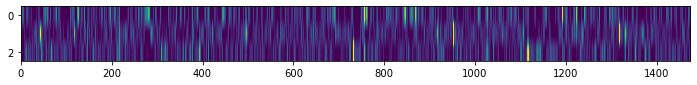

In [21]:
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters,random_state=1015).fit(result)

kmeans.cluster_centers_.shape

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.imshow(kmeans.cluster_centers_,aspect=40,vmax=0.03)

In [22]:

mean_coord = kmeans.cluster_centers_.mean(axis=0)
mean_words = sorted(zip(mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:12]
mean_words

[(0.05239213192991563, 'manufacturer'),
 (0.05202555879050002, 'platform'),
 (0.04770226498275512, 'retailer'),
 (0.03669212982089888, 'supplier'),
 (0.035647700419872176, 'product'),
 (0.03512934167721422, 'marketplace'),
 (0.028865634015901337, 'seller'),
 (0.027893516353408598, 'sale'),
 (0.027271339407148616, 'consumer'),
 (0.026100551358724213, 'supply chain'),
 (0.025793286352291847, 'firm'),
 (0.02396981069554477, 'e tailer')]

In [23]:
cc = kmeans.cluster_centers_
k = []
for i in range(n_clusters):
    k.append(sorted(zip(cc[i,:]-mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:12])

k[:2]

[[(0.03989214973505532, 'marketplace'),
  (0.036393631286866776, 'o2o platform'),
  (0.03617677718784387, 'online marketplace'),
  (0.029907635729479944, 'marketplace system'),
  (0.029607599441384372, 'seller'),
  (0.029298921829619018, 'omnichannel management'),
  (0.027648024703836434, 'er'),
  (0.027206043267134085, 'datum quality'),
  (0.025944418458434336, 'brand manufacturer'),
  (0.021991539504517987, 'buyer'),
  (0.021768293243111338, 'o.r'),
  (0.021608001578665055, 'wom')],
 [(0.08372108903278527, 'platform'),
  (0.06672409751227246, 'supplier'),
  (0.03158033641624898, 'agency contract'),
  (0.02574043532616127, 'blockchain'),
  (0.024373483597554077, 'firm'),
  (0.021373655817461527, 'em'),
  (0.02076730778450673, 'p2p marketplace'),
  (0.019396204435683292, 'supply chain'),
  (0.01929335167173416, 'logistic service'),
  (0.0189802686927042, 'service provider'),
  (0.018208426521577087, 'ddm'),
  (0.017881831298545252, 'market potential')]]

In [24]:
k50 = []
for i in range(n_clusters):
    k50.append(sorted(zip(cc[i,:]-mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:50])



In [25]:
k50[0]

[(0.03989214973505532, 'marketplace'),
 (0.036393631286866776, 'o2o platform'),
 (0.03617677718784387, 'online marketplace'),
 (0.029907635729479944, 'marketplace system'),
 (0.029607599441384372, 'seller'),
 (0.029298921829619018, 'omnichannel management'),
 (0.027648024703836434, 'er'),
 (0.027206043267134085, 'datum quality'),
 (0.025944418458434336, 'brand manufacturer'),
 (0.021991539504517987, 'buyer'),
 (0.021768293243111338, 'o.r'),
 (0.021608001578665055, 'wom'),
 (0.021608001578665055, 'logistic information'),
 (0.021605508121811102, 'sale'),
 (0.02158005589603377, 'setting'),
 (0.021103084139554786, 'review volume'),
 (0.021103084139554786, 'rating'),
 (0.021045946957180366, 'sme'),
 (0.020755534766747463, 'brand'),
 (0.01971013716407965, 'competitor'),
 (0.01582731310466609, 'sale rank'),
 (0.01582731310466609, 'discount'),
 (0.015566651075060597, 'marketplace platform'),
 (0.015407650135179338, 'vendor'),
 (0.015407650135179338, 'compete vendor'),
 (0.015407650135179338, '

In [26]:
df = pd.concat([pd.DataFrame(data=v, columns= ['score','words']) for i,v in enumerate(k)],axis=0)
df['cluster'] = sum([[i]*12 for i in range(n_clusters)],[]) 
df = df[df.columns[::-1]]
df

,cluster,words,score
0,0,marketplace,0.039892
1,0,o2o platform,0.036394
2,0,online marketplace,0.036177
3,0,marketplace system,0.029908
4,0,seller,0.029608
5,0,omnichannel management,0.029299
6,0,er,0.027648
7,0,datum quality,0.027206
8,0,brand manufacturer,0.025944
9,0,buyer,0.021992


In [27]:
df.groupby('cluster')['words'].apply( lambda w: '; '.join(w))

cluster
0    marketplace; o2o platform; online marketplace;...
1    platform; supplier; agency contract; blockchai...
2    manufacturer; retailer; demand; e tailer; tail...
Name: words, dtype: object

In [ ]:
pwd

In [28]:
df.to_excel('marketplace_tf_idf_cluster_main_words.xlsx', index=False)

In [29]:
kmeans.predict(result)


array([1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1,
       0, 1, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2,
       2, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1], dtype=int32)

In [30]:
cluster_affinity = np.array([1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1,
       0, 1, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2,
       2, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1],
      dtype=np.int32)

In [31]:
cluster_sets =[[x[1] for x in k] for k in k50]

In [32]:
article_tokens = {k: set(spacy_clean_tokenizer(v)) for k,v in article_abstract_dict.items()}

In [33]:
from collections import Counter
c = Counter()
for v in article_tokens.values():
    c.update(v)
    

In [34]:
len(c)

1478

In [35]:
[(it,v) for it,v in c.items() if 'revenue' in it]

[('revenue', 4),
 ('sale revenue', 1),
 ('revenue share rate', 1),
 ('revenue sharing', 4),
 ('revenue sharing rate', 1),
 ('revenue sharing rate increase', 1),
 ('identical revenue share term', 1),
 ('revenue sharing contract format', 1),
 ('revenue sharing contract', 1),
 ('widely use pricing scheme revenue sharing', 1),
 ('supply chain revenue cost function', 1),
 ('revenue sharing portion', 1),
 ('revenue sharing scheme', 1),
 ('revenue share contract', 1),
 ('platform lead revenue sharing contract', 1),
 ('i.e. seller revenue share', 1),
 ('retailer revenue sharing decision', 1),
 ('retailer revenue share', 1),
 ('revenue sharing requirement', 1),
 ('smart revenue sharing contract', 1)]

In [36]:
def get_article_indetifiers():
    for (article_name, article_words), cluster  in \
            zip(article_tokens.items(), tqdm(cluster_affinity)):
        cluster_words = cluster_sets[cluster]
        joint_words = [word for word in cluster_words if word in article_words and c[word]>=3][:15]
        yield article_name, cluster, joint_words

In [37]:
cluster_summary = pd.DataFrame(
        data=list(get_article_indetifiers()), 
        columns = 'article_name, cluster, article_words'.split(', ')
    )

cluster_summary['article_words'] = cluster_summary.article_words.map(', '.join)
cluster_summary = cluster_summary.sort_values(['cluster','article_name'])
cluster_summary

 98%|█████████▊| 57/58 [00:00<00:00, 81401.20it/s]


,article_name,cluster,article_words
14,Cai and Lo 2020,0,
25,Chen et al 2019,0,"marketplace, setting, article, benefit"
48,Hagiu and Wright 2020,0,article
22,He et al 2020,0,
38,Li et al 2016,0,sale
54,Luo et al 2020,0,"online marketplace, seller, sale"
35,Renna 2010,0,"marketplace, benefit"
56,Ryan et al 2012,0,"marketplace, online marketplace, seller, buyer..."
13,Schlosser and Boissier 2018,0,"sale, set"
16,Yenipazarli 2020,0,"marketplace, online marketplace, sale, setting"


In [38]:
cluster_summary.to_excel('marketplace_tf_idf3.xlsx', index=False)

In [39]:
df2 = pd.DataFrame({'file_name': list(article_abstract_dict.keys()), 'cluster': kmeans.predict(result)})
df2=df2.sort_values(['cluster','file_name'])

In [40]:
word_series = df.groupby('cluster')['words'].apply( lambda w: '; '.join(w))
df2['words']=''
for cl,gr in df2.groupby('cluster'):
#     print(cl)
#     print(gr.columns)
    df2['words'][gr['words'].index[0]] = word_series[cl]

<ipython-input-40-14fec56918fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['words'][gr['words'].index[0]] = word_series[cl]


In [41]:
df2

,file_name,cluster,words
14,Cai and Lo 2020,0,marketplace; o2o platform; online marketplace;...
25,Chen et al 2019,0,
48,Hagiu and Wright 2020,0,
22,He et al 2020,0,
38,Li et al 2016,0,
54,Luo et al 2020,0,
35,Renna 2010,0,
56,Ryan et al 2012,0,
13,Schlosser and Boissier 2018,0,
16,Yenipazarli 2020,0,


In [42]:
kmeans.cluster_centers_.shape



(3, 1474)

In [43]:
df2.to_excel('marketplace_tf_idf_cluster_contents3.xlsx',sheet_name='clusters', index=False)

In [45]:
cluster_centers_pca = PCA()
cluster_centers_pca.fit(kmeans.cluster_centers_)

PCA()

In [46]:
np.round(np.cumsum(cluster_centers_pca.explained_variance_ratio_),3)

array([0.549, 1.   , 1.   ])

In [47]:
cluster_centers_pca.components_ 

array([[-1.03718813e-02,  4.59829386e-02,  3.04295610e-02, ...,
        -7.00013252e-03,  2.19218032e-02, -7.00926558e-03],
       [-1.88677918e-02, -1.10589355e-03, -7.31833509e-04, ...,
         1.40828963e-02, -5.27221217e-04,  1.41012703e-02],
       [ 3.38698349e-01, -7.49729684e-01, -1.09379771e-03, ...,
        -8.05808414e-03, -1.08418537e-02, -4.74956644e-03]])

In [48]:
cluster_centers_pca = PCA(2)
emb = cluster_centers_pca.fit_transform(kmeans.cluster_centers_)

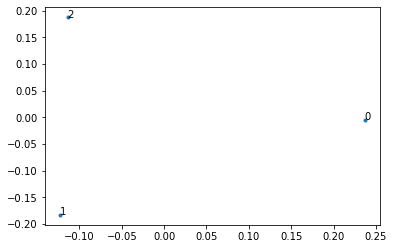

In [49]:
plt.plot(emb[:,0], emb[:,1],'.')

for i,r in enumerate(emb):
    plt.text(r[0],r[1],str(i))

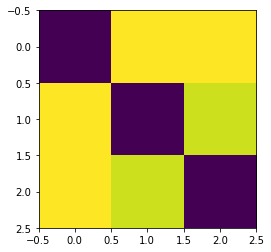

In [50]:
plt.imshow(distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_))

In [51]:
np.round(distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_).mean(axis=0),3)

array([0.267, 0.258, 0.257])

In [52]:

mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=6)
results = mds.fit(kmeans.cluster_centers_)

coords = results.embedding_


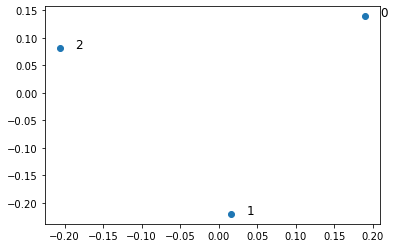

In [53]:
plt.plot(coords[:,0], coords[:,1],'o')

for i,r in enumerate(coords):
    plt.text(r[0]+0.02,r[1],str(i),fontsize=12)

In [54]:
result.shape

(58, 1474)

In [56]:
point_coord = []
for cl in range(n_clusters):
    points = result[cluster_affinity==cl,:] - kmeans.cluster_centers_[i,:]
    
    points2d = mds.fit(points).embedding_ + coords[i,:]
    point_coord.append(points2d)

In [57]:
point_stats = []
for cl in range(n_clusters):
    points_dist = distance_matrix(result[cluster_affinity==cl,:].todense(),kmeans.cluster_centers_)
    points_dist = (points_dist**2).mean(axis=0)
    point_stats.append(points_dist)

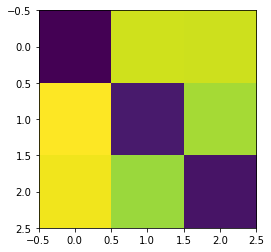

In [58]:
plt.imshow(np.vstack(point_stats))

In [59]:
np.round(np.vstack(point_stats),3)

array([[0.899, 1.06 , 1.058],
       [1.072, 0.911, 1.049],
       [1.068, 1.046, 0.908]])

In [60]:
import matplotlib.cm as cm

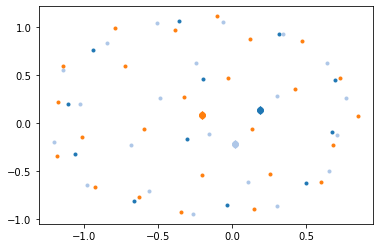

In [61]:

for i,r in enumerate(coords):
    plt.plot(coords[i,0], coords[i,1],'o',color = cm.tab20(i))
    plt.plot(coords[i,0], coords[i,1],'d',color = cm.tab20(i))

    plt.plot(point_coord[i][:,0], point_coord[i][:,1],'.',color = cm.tab20(i))

In [ ]:
points2d

In [ ]:
result[cluster_affinity==2,:].todense().shape

In [67]:
community = {"Cao et al 2020": 0, "Chen et al 2020": 0, "Li et al 2019": 1, "Chen et al 2019": 1, "Wang et al 2019": 0, "Cao et al 2019": 0, "Zhen et al 2020": 0, "Avinadav et al 2015a": 8, "Mantin et al 2014": 0, "Shen et al 2019": 0, "Qin et al 2020": 1, "Avinadav et al 2017": 8, "Zennyo 2020": 1, "He et al 2020": 1, "Li 2020": 1, "Avinadav et al 2019": 8, "Avinadav et al 2015b": 8, "Yenipazarli 2020": 0, "Tian et al 2018": 0, "Cai and Lo 2020": 1, "Chernonog 2020": 8, "Ryan et al 2012": 0, "Avinadav et al 2020b": 8, "Alaei et al 2020": 1, "Xu et al 2020": 1, "de Matta et al 2017": 0, "Zhang and Zhang 2019": 0, "Qin et al 2020b": 1, "Shen et al 2019b": 0, "Li et al 2020": 1, "Guo et al 2020": 1, "Zhang and Zhang 2020": 0, "He et al 2021": 1, "Liu et al 2020": 1, "Avinadav et al 2020": 8, "Shen et al 2020": 1, "Yan et al 2019": 0, "Yan et al 2018": 0, "Geng et al 2018": 1, "Abhishek et al 2016": 0}

In [77]:
cluster_summary['community'] = cluster_summary.article_name.map(lambda n: {0: "A", 1:"B", 8:"C"}.get(community.get(n),''))
cluster_summary.head()

,article_name,cluster,article_words,community
14,Cai and Lo 2020,0,,B
25,Chen et al 2019,0,"marketplace, setting, article, benefit",B
48,Hagiu and Wright 2020,0,article,
22,He et al 2020,0,,B
38,Li et al 2016,0,sale,


In [76]:
cluster_summary.to_excel('marketplace_tf_idf3.xlsx', index=False)

In [74]:
len(community.keys())

40